In [1165]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pingouin
import statsmodels
from statsmodels.stats.proportion import proportions_ztest
import researchpy as rp

In [1166]:
data=pd.read_csv("/Users/luisnakayama/Desktop/ibge/data_internet.csv")

In [1167]:
data.head()

,id,state,region,house_type,internet,gender,age,race,educational_level,ultima_consulta_medico,dificuldade_atividades_diarias,diabetes_restriction,populacao,renda_per_capita
0,1,rondonia,north,1,1,2,55,1.0,Antigo primário (elementar),Até 1 ano,NaN,NaN,529479,350.0
1,2,rondonia,north,1,1,1,69,4.0,NaN,Até 1 ano,0.0,NaN,529479,350.0
2,3,rondonia,north,1,1,1,31,2.0,Regular do ensino médio ou do 2º grau,Até 1 ano,NaN,NaN,529479,350.0
3,4,rondonia,north,1,1,1,9,2.0,NaN,Até 1 ano,NaN,NaN,529479,350.0
4,5,rondonia,north,1,1,2,6,4.0,NaN,Até 1 ano,NaN,NaN,529479,350.0


In [1168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279382 entries, 0 to 279381
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              279382 non-null  int64  
 1   state                           279382 non-null  object 
 2   region                          279382 non-null  object 
 3   house_type                      279382 non-null  int64  
 4   internet                        279382 non-null  int64  
 5   gender                          279382 non-null  int64  
 6   age                             279382 non-null  int64  
 7   race                            279358 non-null  float64
 8   educational_level               178013 non-null  object 
 9   ultima_consulta_medico          279382 non-null  object 
 10  dificuldade_atividades_diarias  9250 non-null    float64
 11  diabetes_restriction            7101 non-null    object 
 12  populacao       

In [1169]:
#Changing variables categories

data['gender'] = data.gender.astype('category')
data['house_type'] = data.house_type.astype('category')
data['race'] = data.race.astype('category')
data['internet'] = data.internet.astype('category')
data.dtypes

id                                   int64
state                               object
region                              object
house_type                        category
internet                          category
gender                            category
age                                  int64
race                              category
educational_level                   object
ultima_consulta_medico              object
dificuldade_atividades_diarias     float64
diabetes_restriction                object
populacao                            int64
renda_per_capita                   float64
dtype: object

In [1170]:
#Create income in USD/ anual
data['year_income_usd']=data['renda_per_capita']*12*0.184
data=data.drop(['id','renda_per_capita','populacao'], axis=1)

In [1171]:
#creating age groups
def age_groups(x): 
    if x < 18: return '10to18' 
    elif x < 40: return '19to40' 
    elif x < 60: return '40to59' 
    elif x >=60: return '60+' 
    else: return 'other'
    
    
data['age_group'] = data.age.apply(age_groups)

In [1172]:
def elderly(x): 
    if x < 60: return 'no_elderly' 
    elif x >=60: return 'elderly' 
    else: return 'other'
    
    
data['elderly'] = data.age.apply(elderly)

In [1173]:
def income_less_than_minimum(x): 
    if x < 2203: return 'less_minimum' 
    else: return 'more_minimum'
    
    
data['income_class'] = data.year_income_usd.apply(income_less_than_minimum)

In [1174]:
data.head()

,state,region,house_type,internet,gender,age,race,educational_level,ultima_consulta_medico,dificuldade_atividades_diarias,diabetes_restriction,year_income_usd,age_group,elderly,income_class
0,rondonia,north,1,1,2,55,1.0,Antigo primário (elementar),Até 1 ano,NaN,NaN,772.8,40to59,no_elderly,less_minimum
1,rondonia,north,1,1,1,69,4.0,NaN,Até 1 ano,0.0,NaN,772.8,60+,elderly,less_minimum
2,rondonia,north,1,1,1,31,2.0,Regular do ensino médio ou do 2º grau,Até 1 ano,NaN,NaN,772.8,19to40,no_elderly,less_minimum
3,rondonia,north,1,1,1,9,2.0,NaN,Até 1 ano,NaN,NaN,772.8,10to18,no_elderly,less_minimum
4,rondonia,north,1,1,2,6,4.0,NaN,Até 1 ano,NaN,NaN,772.8,10to18,no_elderly,less_minimum


In [1175]:
data.describe()

,age,dificuldade_atividades_diarias,year_income_usd
count,279382.000000,9250.000000,279210.000000
mean,35.267651,0.394054,2901.314309
std,21.675970,0.488673,5095.361652
min,0.000000,0.000000,0.000000
25%,17.000000,0.000000,880.992000
50%,34.000000,0.000000,1678.080000
75%,52.000000,1.000000,3084.576000
max,112.000000,1.000000,448656.768000


In [1176]:
numerical_features=[features for features in data.columns if data[features].dtype!='O']

print('Number of numerical features' , len(numerical_features))

# discrete features

discrete_features = [features for features in numerical_features if len(data[features].unique())<=10]

print('discrete features', len(discrete_features))
print(discrete_features)

Number of numerical features 7
discrete features 5
['house_type', 'internet', 'gender', 'race', 'dificuldade_atividades_diarias']


continous features 2


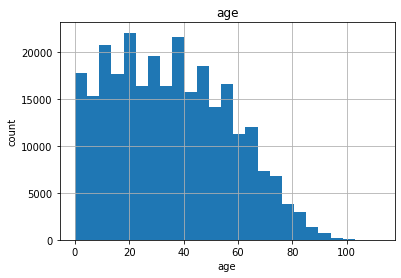

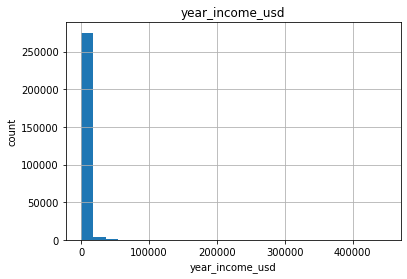

In [1177]:
# continous features

continous_features = [features for features in numerical_features if features not in discrete_features] 

print("continous features" , len(continous_features))

for features in continous_features:
    data = data.copy()
    data[features].hist(bins=25)
    plt.xlabel(features)
    plt.ylabel("count")
    plt.title(features)
    plt.show()

In [1178]:
categorical_features = [features for features in data.columns if data[features].dtype=='O']
print(len(categorical_features))

for features in categorical_features:
    print(f"The feature is {features} and number of categories are {len(data[features].unique())}")

8
The feature is state and number of categories are 27
The feature is region and number of categories are 5
The feature is educational_level and number of categories are 16
The feature is ultima_consulta_medico and number of categories are 5
The feature is diabetes_restriction and number of categories are 6
The feature is age_group and number of categories are 4
The feature is elderly and number of categories are 2
The feature is income_class and number of categories are 2


In [1179]:
#show missing values
data.isna().sum().sort_values()

state                                  0
region                                 0
house_type                             0
internet                               0
gender                                 0
age                                    0
ultima_consulta_medico                 0
age_group                              0
elderly                                0
income_class                           0
race                                  24
year_income_usd                      172
educational_level                 101369
dificuldade_atividades_diarias    270132
diabetes_restriction              272281
dtype: int64

In [1180]:
#proportion of race NA
(data['race'].isna().sum()/len(data['race']))*100

0.00859038878667917

In [1181]:
#proportion of renda NA
(data['year_income_usd'].isna().sum()/len(data['year_income_usd']))*100

0.06156445297120073

In [1182]:
#proportion of educational_level NA
(data['educational_level'].isna().sum()/len(data['educational_level']))*100

36.28329670487003

In [1183]:
#proportion of dificuldade_atividades_diarias NA
(data['dificuldade_atividades_diarias'].isna().sum()/len(data['dificuldade_atividades_diarias']))*100

96.68912098846741

In [1184]:
#proportion of diabetes_restriction NA
(data['diabetes_restriction'].isna().sum()/len(data['diabetes_restriction']))*100

97.45831871774129

In [1185]:
data.region.value_counts()

northeast      99553
north          61447
southeast      56340
south          31238
center_west    30804
Name: region, dtype: int64

In [1186]:
data.region.value_counts(normalize=True)

northeast      0.356333
north          0.219939
southeast      0.201659
south          0.111811
center_west    0.110258
Name: region, dtype: float64

In [1187]:
regions=data.groupby('internet')['region'].value_counts()
regions_norm=data.groupby('internet')['region'].value_counts(normalize=True)
print(regions)
print(regions_norm)

internet  region     
0         northeast      25166
          north          16371
          southeast       6511
          south           4192
          center_west     3575
1         northeast      74387
          southeast      49829
          north          45076
          center_west    27229
          south          27046
Name: region, dtype: int64
internet  region     
0         northeast      0.450882
          north          0.293308
          southeast      0.116653
          south          0.075105
          center_west    0.064051
1         northeast      0.332728
          southeast      0.222882
          north          0.201622
          center_west    0.121793
          south          0.120975
Name: region, dtype: float64


In [1188]:
data.year_income_usd.describe()

count    279210.000000
mean       2901.314309
std        5095.361652
min           0.000000
25%         880.992000
50%        1678.080000
75%        3084.576000
max      448656.768000
Name: year_income_usd, dtype: float64

In [1189]:
data.groupby('internet')['year_income_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
internet,,,,,,,,
0,55802.0,1510.907945,1964.243054,0.0,470.304,1101.792,2203.584,110400.000
1,223408.0,3248.604719,5557.016467,0.0,1028.928,1854.720,3422.400,448656.768


In [1190]:
data.gender.value_counts(normalize=True)

2    0.518788
1    0.481212
Name: gender, dtype: float64

In [1191]:
gender=data.groupby('internet')['gender'].value_counts()
gender_norm=data.groupby('internet')['gender'].value_counts(normalize=True)
print(gender)
print(gender_norm)

internet   
0         1     28394
          2     27421
1         2    117519
          1    106048
Name: gender, dtype: int64
internet   
0         1    0.508716
          2    0.491284
1         2    0.525655
          1    0.474345
Name: gender, dtype: float64


In [1192]:
data.house_type.value_counts(normalize=True)

1    0.759841
2    0.240159
Name: house_type, dtype: float64

In [1193]:
house_type=data.groupby('internet')['house_type'].value_counts()
house_norm=data.groupby('internet')['house_type'].value_counts(normalize=True)
print(house_type)
print(house_norm)

internet   
0         2     31367
          1     24448
1         1    187838
          2     35729
Name: house_type, dtype: int64
internet   
0         2    0.561982
          1    0.438018
1         1    0.840187
          2    0.159813
Name: house_type, dtype: float64


In [1194]:
data.race.value_counts(normalize=True)

4.0    0.530763
1.0    0.354452
2.0    0.101318
5.0    0.007388
3.0    0.006078
Name: race, dtype: float64

In [1195]:
race=data.groupby('internet')['race'].value_counts()
race_norm=data.groupby('internet')['race'].value_counts(normalize=True)
print(race)
print(race_norm)

internet     
0         4.0     34678
          1.0     14225
          2.0      6042
          5.0       657
          3.0       211
1         4.0    113595
          1.0     84794
          2.0     22262
          3.0      1487
          5.0      1407
Name: race, dtype: int64
internet     
0         4.0    0.621325
          1.0    0.254869
          2.0    0.108254
          5.0    0.011771
          3.0    0.003780
1         4.0    0.508153
          1.0    0.379315
          2.0    0.099586
          3.0    0.006652
          5.0    0.006294
Name: race, dtype: float64


In [1196]:
data.educational_level.value_counts()

Regular do ensino médio ou do 2º grau                                    63175
Regular do ensino fundamental ou do 1º grau                              46411
Superior – graduação                                                     24223
Antigo primário (elementar)                                              19241
Especialização de nível superior (duração mínima de 360 horas)            6345
Antigo ginasial (médio 1º ciclo)                                          3677
Classe de alfabetização – CA                                              3552
Educação de jovens e adultos (EJA) ou supletivo do ensino médio           3025
Antigo científico, clássico etc. (médio 2º ciclo)                         2442
Educação de jovens e adultos (EJA) ou supletivo do ensino fundamental     2415
Mestrado                                                                  1059
Alfabetização de jovens e adultos                                         1022
Pré-escola                                          

In [1197]:
education=data.groupby('internet')['educational_level'].value_counts()
education_norm=data.groupby('internet')['educational_level'].value_counts(normalize=True)
print(education)
print(education_norm)

internet  educational_level                                                    
0         Regular do ensino fundamental ou do 1º grau                              13283
          Antigo primário (elementar)                                               7916
          Regular do ensino médio ou do 2º grau                                     6976
          Classe de alfabetização – CA                                              2029
          Superior – graduação                                                       895
          Antigo ginasial (médio 1º ciclo)                                           872
          Educação de jovens e adultos (EJA) ou supletivo do ensino fundamental      741
          Alfabetização de jovens e adultos                                          494
          Educação de jovens e adultos (EJA) ou supletivo do ensino médio            354
          Antigo científico, clássico etc. (médio 2º ciclo)                          353
          Pré-escola          

In [1198]:
comparacao= data.sort_values('year_income_usd').groupby('internet').agg(['mean','std'])
comparacao

age            dificuldade_atividades_diarias            \
               mean        std                           mean       std   
internet                                                                  
0         40.670196  24.835676                       0.363039  0.480939   
1         33.918870  20.592567                       0.415718  0.492891   

         year_income_usd               
                    mean          std  
internet                               
0            1510.907945  1964.243054  
1            3248.604719  5557.016467

In [1199]:
data.age.describe()

count    279382.000000
mean         35.267651
std          21.675970
min           0.000000
25%          17.000000
50%          34.000000
75%          52.000000
max         112.000000
Name: age, dtype: float64

In [1200]:
age=data.groupby('internet')['age'].describe()
print(age)

             count       mean        std  min   25%   50%   75%    max
internet                                                              
0          55815.0  40.670196  24.835676  0.0  18.0  41.0  62.0  107.0
1         223567.0  33.918870  20.592567  0.0  17.0  33.0  49.0  112.0


In [1201]:
data.elderly.value_counts()

no_elderly    235828
elderly        43554
Name: elderly, dtype: int64

In [1202]:
data.elderly.value_counts(normalize=True)

no_elderly    0.844106
elderly       0.155894
Name: elderly, dtype: float64

In [1203]:
data.groupby('internet')['elderly'].value_counts()


internet  elderly   
0         no_elderly     40287
          elderly        15528
1         no_elderly    195541
          elderly        28026
Name: elderly, dtype: int64

In [1204]:
data.groupby('internet')['elderly'].value_counts(normalize=True)

internet  elderly   
0         no_elderly    0.721795
          elderly       0.278205
1         no_elderly    0.874642
          elderly       0.125358
Name: elderly, dtype: float64

In [1205]:
#chi square of independence
alpha = 0.05


<AxesSubplot:xlabel='elderly'>

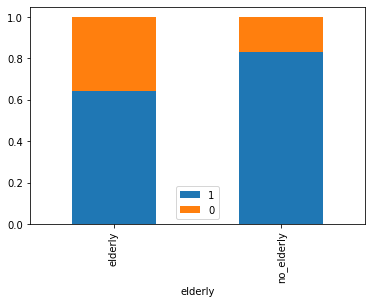

In [1206]:
proportions=data.groupby('elderly')['internet'].value_counts(normalize=True)
wide_proportions = proportions.unstack()

wide_proportions.plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='educational_level'>

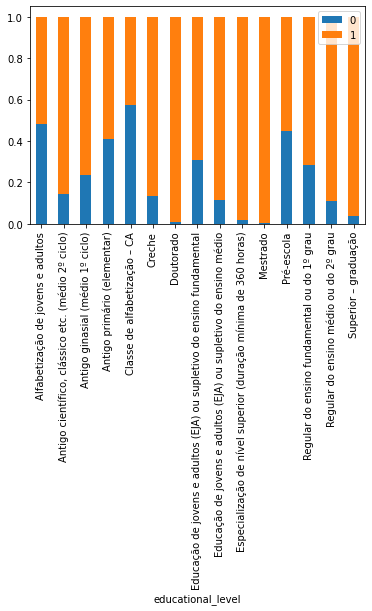

In [1207]:
proportions=data.groupby('educational_level')['internet'].value_counts(normalize=True)
wide_proportions = proportions.unstack()

wide_proportions.plot(kind='bar', stacked=True)

In [1208]:
expected, observed, stats = pingouin.chi2_independence(data=data, x="internet", y='educational_level')
print(stats[stats['test'] == 'pearson'])

      test  lambda          chi2   dof  pval   cramer  power
0  pearson     1.0  21063.709214  14.0   0.0  0.27458    1.0


/Users/luisnakayama/miniforge3/lib/python3.9/site-packages/pingouin/contingency.py:150: UserWarning: Low count on observed frequencies.
  warnings.warn("Low count on {} frequencies.".format(name))


<AxesSubplot:xlabel='house_type'>

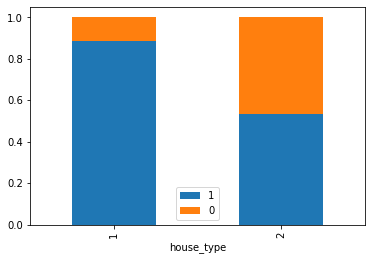

In [1209]:
proportions=data.groupby('house_type')['internet'].value_counts(normalize=True)
wide_proportions = proportions.unstack()

wide_proportions.plot(kind='bar', stacked=True)

In [1210]:
expected, observed, stats = pingouin.chi2_independence(data=data, x="internet", y='house_type')
print(stats[stats['test'] == 'pearson'])

      test  lambda          chi2  dof  pval    cramer  power
0  pearson     1.0  39584.963587  1.0   0.0  0.376414    1.0


<AxesSubplot:xlabel='gender'>

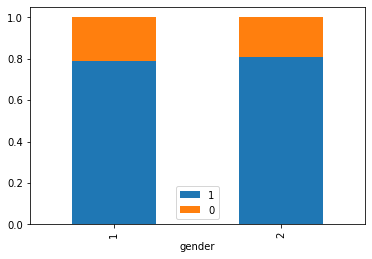

In [1211]:
proportions=data.groupby('gender')['internet'].value_counts(normalize=True)
wide_proportions = proportions.unstack()

wide_proportions.plot(kind='bar', stacked=True)

In [1212]:
expected, observed, stats = pingouin.chi2_independence(data=data, x="internet", y='gender')
print(stats[stats['test'] == 'pearson'])

      test  lambda        chi2  dof          pval    cramer  power
0  pearson     1.0  211.217588  1.0  7.451199e-48  0.027496    1.0


<AxesSubplot:xlabel='race'>

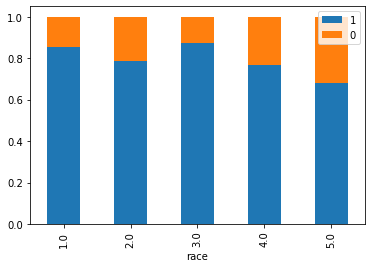

In [1213]:
proportions=data.groupby('race')['internet'].value_counts(normalize=True)
wide_proportions = proportions.unstack()

wide_proportions.plot(kind='bar', stacked=True)

In [1214]:
expected, observed, stats = pingouin.chi2_independence(data=data, x="internet", y='race')
print(stats[stats['test'] == 'pearson'])

      test  lambda         chi2  dof  pval    cramer  power
0  pearson     1.0  3304.206009  4.0   0.0  0.108751    1.0


<AxesSubplot:xlabel='region'>

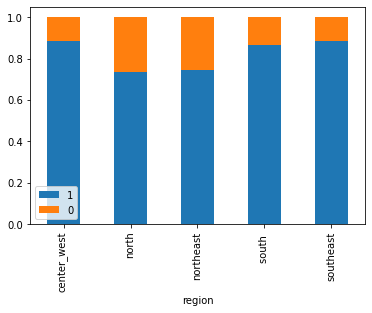

In [1215]:
proportions=data.groupby('region')['internet'].value_counts(normalize=True)
wide_proportions = proportions.unstack()

wide_proportions.plot(kind='bar', stacked=True)

In [1216]:
expected, observed, stats = pingouin.chi2_independence(data=data, x="internet", y='region')
print(stats[stats['test'] == 'pearson'])

      test  lambda         chi2  dof  pval   cramer  power
0  pearson     1.0  8147.459454  4.0   0.0  0.17077    1.0


In [1217]:
expected, observed, stats = pingouin.chi2_independence(data=data, x="internet", y='elderly')
print(stats[stats['test'] == 'pearson'])

      test  lambda         chi2  dof  pval    cramer  power
0  pearson     1.0  7928.305718  1.0   0.0  0.168458    1.0


In [1218]:
expected, observed, stats = pingouin.chi2_independence(data=data, x="internet", y='race')
print(stats[stats['test'] == 'pearson'])

      test  lambda         chi2  dof  pval    cramer  power
0  pearson     1.0  3304.206009  4.0   0.0  0.108751    1.0


In [1219]:
expected, observed, stats = pingouin.chi2_independence(data=data, x="internet", y='diabetes_restriction')
print(stats[stats['test'] == 'pearson'])

      test  lambda       chi2  dof          pval    cramer  power
0  pearson     1.0  62.017072  4.0  1.092521e-12  0.014899    1.0


In [1220]:
expected, observed, stats = pingouin.chi2_independence(data=data, x="internet", y='dificuldade_atividades_diarias')
print(stats[stats['test'] == 'pearson'])

      test  lambda       chi2  dof          pval    cramer     power
0  pearson     1.0  25.809154  1.0  3.768967e-07  0.009611  0.999097


In [1221]:
#T test year income and internet use

rp.ttest(group1= data['year_income_usd'][data['internet'] == 0], group1_name= "no_int",
         group2= data['year_income_usd'][data['internet'] == 1], group2_name= "int")

(   Variable         N         Mean           SD         SE    95% Conf.  \
 0    no_int   55802.0  1510.907945  1964.243054   8.315155  1494.610187   
 1       int  223408.0  3248.604719  5557.016467  11.756886  3225.561520   
 2  combined  279210.0  2901.314309  5095.361652   9.642941  2882.414409   
 
       Interval  
 0  1527.205702  
 1  3271.647918  
 2  2920.214209  ,
              Independent t-test      results
 0  Difference (no_int - int) =    -1737.6968
 1         Degrees of freedom =   279208.0000
 2                          t =      -72.7417
 3      Two side test p value =        0.0000
 4     Difference < 0 p value =        0.0000
 5     Difference > 0 p value =        1.0000
 6                  Cohen's d =       -0.3443
 7                  Hedge's g =       -0.3442
 8             Glass's delta1 =       -0.8847
 9           Point-Biserial r =       -0.1364)

In [1222]:
##T test age and internet use

rp.ttest(group1= data['age'][data['internet'] == 0], group1_name= "no_int",
         group2= data['age'][data['internet'] == 1], group2_name= "int")

(   Variable         N       Mean         SD        SE  95% Conf.   Interval
 0    no_int   55815.0  40.670196  24.835676  0.105124  40.464153  40.876239
 1       int  223567.0  33.918870  20.592567  0.043552  33.833509  34.004230
 2  combined  279382.0  35.267651  21.675970  0.041009  35.187275  35.348028,
              Independent t-test      results
 0  Difference (no_int - int) =        6.7513
 1         Degrees of freedom =   279380.0000
 2                          t =       66.3413
 3      Two side test p value =        0.0000
 4     Difference < 0 p value =        1.0000
 5     Difference > 0 p value =        0.0000
 6                  Cohen's d =        0.3139
 7                  Hedge's g =        0.3139
 8             Glass's delta1 =        0.2718
 9           Point-Biserial r =        0.1245)

In [1223]:
#internet and house type group comparison
house_type=data.groupby('house_type')['internet'].value_counts()
house_type

house_type   
1           1    187838
            0     24448
2           1     35729
            0     31367
Name: internet, dtype: int64

In [1224]:
success_counts=np.array([187838,35729])

In [1225]:
n = np.array([212286, 67096])

In [1226]:
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative ='larger')
print('{0:0.3f}'.format(p_value))

0.000


In [1227]:
#Gender
gender=data.groupby('gender')['internet'].value_counts()
gender

gender   
1       1    106048
        0     28394
2       1    117519
        0     27421
Name: internet, dtype: int64

In [1228]:
success_counts=np.array([106048,117519])
n = np.array([134442, 144940])

In [1229]:
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative ='larger')
print('{0:0.3f}'.format(p_value))

1.000


In [1230]:
#race all vs white
race=data.groupby('race')['internet'].value_counts()
race

race   
1.0   1     84794
      0     14225
2.0   1     22262
      0      6042
3.0   1      1487
      0       211
4.0   1    113595
      0     34678
5.0   1      1407
      0       657
Name: internet, dtype: int64

In [1231]:
#white vs black
success_counts=np.array([84794,22262])
n = np.array([99019, 28304])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative ='two-sided')
print('{0:0.3f}'.format(p_value))

0.000


In [1232]:
#white vs yellow
success_counts=np.array([84794,1487])
n = np.array([99019, 1698])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative ='two-sided')
print('{0:0.3f}'.format(p_value))

0.024


In [1233]:
#white vs brown
success_counts=np.array([84794,113595])
n = np.array([99019, 148273])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative ='two-sided')
print('{0:0.3f}'.format(p_value))

0.000


In [1234]:
#white vs other
success_counts=np.array([84794,1407])
n = np.array([99019, 2064])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative ='two-sided')
print('{0:0.3f}'.format(p_value))

0.000


In [1235]:
#regions southeast vs all
#southeast with higher proportional internet users
region=data.groupby('region')['internet'].value_counts()
region

region        
center_west  1    27229
             0     3575
north        1    45076
             0    16371
northeast    1    74387
             0    25166
south        1    27046
             0     4192
southeast    1    49829
             0     6511
Name: internet, dtype: int64

In [1236]:
#southeast vs north
success_counts=np.array([49829,45076])
n = np.array([56340, 61393])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative ='two-sided')
print('{0:0.3f}'.format(p_value))

0.000


In [1237]:
#southeast vs northeast
success_counts=np.array([49829,74387])
n = np.array([56340, 99553])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative ='two-sided')
print('{0:0.3f}'.format(p_value))

0.000


In [1238]:
#southeast vs center west
success_counts=np.array([49829,27229])
n = np.array([56340, 30804])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative ='two-sided')
print('{0:0.3f}'.format(p_value))

0.829


In [1239]:
#southeast vs south
success_counts=np.array([49829,27046])
n = np.array([56340, 31238])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative ='two-sided')
print('{0:0.4f}'.format(p_value))

0.0000


In [1240]:
data.groupby('internet')['educational_level'].value_counts()

internet  educational_level                                                    
0         Regular do ensino fundamental ou do 1º grau                              13283
          Antigo primário (elementar)                                               7916
          Regular do ensino médio ou do 2º grau                                     6976
          Classe de alfabetização – CA                                              2029
          Superior – graduação                                                       895
          Antigo ginasial (médio 1º ciclo)                                           872
          Educação de jovens e adultos (EJA) ou supletivo do ensino fundamental      741
          Alfabetização de jovens e adultos                                          494
          Educação de jovens e adultos (EJA) ou supletivo do ensino médio            354
          Antigo científico, clássico etc. (médio 2º ciclo)                          353
          Pré-escola          

In [1241]:
data.groupby('internet')['educational_level'].value_counts(normalize=True)

internet  educational_level                                                    
0         Regular do ensino fundamental ou do 1º grau                              0.386415
          Antigo primário (elementar)                                              0.230284
          Regular do ensino médio ou do 2º grau                                    0.202938
          Classe de alfabetização – CA                                             0.059025
          Superior – graduação                                                     0.026036
          Antigo ginasial (médio 1º ciclo)                                         0.025367
          Educação de jovens e adultos (EJA) ou supletivo do ensino fundamental    0.021556
          Alfabetização de jovens e adultos                                        0.014371
          Educação de jovens e adultos (EJA) ou supletivo do ensino médio          0.010298
          Antigo científico, clássico etc. (médio 2º ciclo)                        0.010269


In [1242]:
data.diabetes_restriction.value_counts()

0 limita              4724
Um pouco              1365
Moderadamente          604
Intensamente           307
Muito intensamente     101
Name: diabetes_restriction, dtype: int64

In [1243]:
data.diabetes_restriction.value_counts()


0 limita              4724
Um pouco              1365
Moderadamente          604
Intensamente           307
Muito intensamente     101
Name: diabetes_restriction, dtype: int64

In [1244]:
data.groupby('internet')['diabetes_restriction'].value_counts()

internet  diabetes_restriction
0         0 limita                1444
          Um pouco                 547
          Moderadamente            231
          Intensamente             121
          Muito intensamente        46
1         0 limita                3280
          Um pouco                 818
          Moderadamente            373
          Intensamente             186
          Muito intensamente        55
Name: diabetes_restriction, dtype: int64

In [1245]:
data.groupby('internet')['diabetes_restriction'].value_counts(normalize=True)

internet  diabetes_restriction
0         0 limita                0.604437
          Um pouco                0.228966
          Moderadamente           0.096693
          Intensamente            0.050649
          Muito intensamente      0.019255
1         0 limita                0.696095
          Um pouco                0.173599
          Moderadamente           0.079160
          Intensamente            0.039474
          Muito intensamente      0.011672
Name: diabetes_restriction, dtype: float64

In [1246]:
#diabetes restrictions 
success_counts=np.array([945,1432])
n = np.array([2389, 4712])
stat, p_value = proportions_ztest(count=success_counts, nobs=n)
print('{0:0.3f}'.format(p_value))

0.000


In [1247]:
data.dificuldade_atividades_diarias.value_counts()

0.0    5605
1.0    3645
Name: dificuldade_atividades_diarias, dtype: int64

In [1248]:
data.groupby('dificuldade_atividades_diarias')['internet'].value_counts()

dificuldade_atividades_diarias   
0.0                             1    3182
                                0    2423
1.0                             1    2264
                                0    1381
Name: internet, dtype: int64

In [1249]:
#limitations 
success_counts=np.array([3182,2264])
n = np.array([5605, 3645])
stat, p_value = proportions_ztest(count=success_counts, nobs=n)
print('{0:0.3f}'.format(p_value))

0.000


In [1250]:
data.groupby('internet')['ultima_consulta_medico'].value_counts()

internet  ultima_consulta_medico 
0         Até 1 ano                   38335
          Mais de 1 ano a 2 anos       7870
          Mais de 3 anos               5902
          Mais de 2 anos a 3 anos      2854
          Nunca foi ao médico           854
1         Até 1 ano                  168049
          Mais de 1 ano a 2 anos      30564
          Mais de 3 anos              14577
          Mais de 2 anos a 3 anos      9225
          Nunca foi ao médico          1152
Name: ultima_consulta_medico, dtype: int64

In [1251]:
data.groupby('internet')['elderly'].value_counts()


internet  elderly   
0         no_elderly     40287
          elderly        15528
1         no_elderly    195541
          elderly        28026
Name: elderly, dtype: int64

In [1252]:
#elderly vs non-elderly
success_counts=np.array([15528,28026])
n = np.array([55815, 223567])
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative ='two-sided')
print('{0:0.3f}'.format(p_value))

0.000


Logistic regression

In [1253]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,dificuldade_atividades_diarias,year_income_usd
age,1.000000,0.295724,0.162242
dificuldade_atividades_diarias,0.295724,1.000000,-0.011220
year_income_usd,0.162242,-0.011220,1.000000


In [1254]:
data.isna().sum().sort_values()


state                                  0
region                                 0
house_type                             0
internet                               0
gender                                 0
age                                    0
ultima_consulta_medico                 0
age_group                              0
elderly                                0
income_class                           0
race                                  24
year_income_usd                      172
educational_level                 101369
dificuldade_atividades_diarias    270132
diabetes_restriction              272281
dtype: int64

In [1255]:

#opted to drop educational_level, dificuldade_atividades_diarias, diabetes_restriction due to to many NA values
data_clean=data.drop(['educational_level','dificuldade_atividades_diarias','diabetes_restriction'], axis=1)
data_clean=data_clean.dropna()
data_clean.isna().sum().sort_values()

state                     0
region                    0
house_type                0
internet                  0
gender                    0
age                       0
race                      0
ultima_consulta_medico    0
year_income_usd           0
age_group                 0
elderly                   0
income_class              0
dtype: int64

In [1256]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279186 entries, 0 to 279381
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   state                   279186 non-null  object  
 1   region                  279186 non-null  object  
 2   house_type              279186 non-null  category
 3   internet                279186 non-null  category
 4   gender                  279186 non-null  category
 5   age                     279186 non-null  int64   
 6   race                    279186 non-null  category
 7   ultima_consulta_medico  279186 non-null  object  
 8   year_income_usd         279186 non-null  float64 
 9   age_group               279186 non-null  object  
 10  elderly                 279186 non-null  object  
 11  income_class            279186 non-null  object  
dtypes: category(4), float64(1), int64(1), object(6)
memory usage: 20.2+ MB


In [1257]:
data_clean.to_csv('data_clean2.csv')